<a href="https://colab.research.google.com/github/nayanpunmiya/Optimized-AI-ML-Models-for-Personalized-Travel-Itineraries/blob/main/crowd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

STEP 1: Dataset loaded.
STEP 2: Target variable 'people_count_norm' created.
STEP 3: Image preprocessing complete with resizing and normalization.


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 114MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i


Training and evaluating FineTunedResNet50...

Training and evaluating FineTunedMobileNetV2...

Training and evaluating MCNN...

STEP 6: Compare Results

FineTunedResNet50 - MAE: 1521.15, RMSE: 2114.05, R²: -1.37

FineTunedMobileNetV2 - MAE: 2383.18, RMSE: 3032.79, R²: -3.87

MCNN - MAE: 1552.92, RMSE: 2060.76, R²: -1.25

STEP 6: Best Model Selection
Best Model: FineTunedResNet50
MAE: 1521.15, RMSE: 2114.05, R²: -1.37


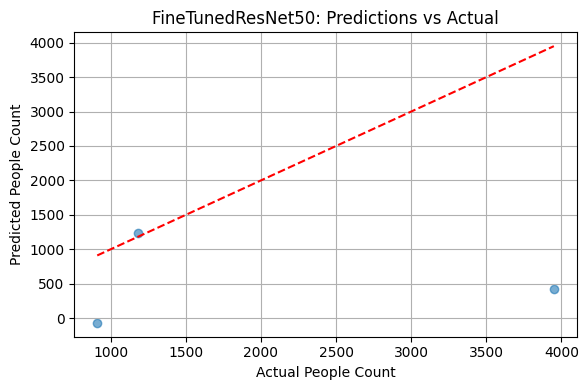

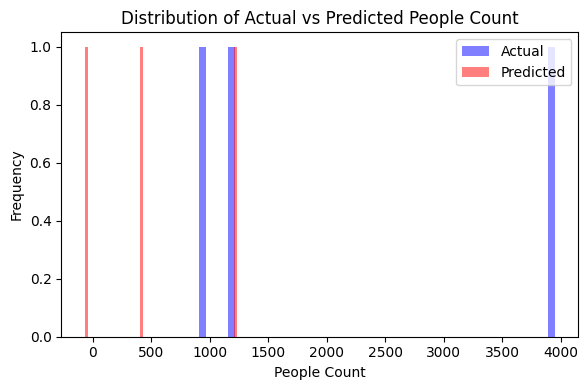


STEP 8: Final Model Selection - Best Model
Justification:
The best model, FineTunedResNet50, was selected based on its lowest MAE. This model demonstrates superior performance in predicting crowd sizes, with metrics (MAE: 1521.15, RMSE: 2114.05, R²: -1.37). We trained it with **no additional augmentations or tuning**, and fine-tuned it on the base dataset.


In [ ]:
n# ✅ STEP 1: Load Dataset
import zipfile
import os
import pandas as pd

zip_path = "/content/archive (6).zip"
extract_dir = "/content/crowd_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

df = pd.read_csv(os.path.join(extract_dir, "crowds_counting.csv"))
print("STEP 1: Dataset loaded.")

# ✅ STEP 2: Define Target Variable
import json

def count_people(label_path):
    full_path = os.path.join(extract_dir, label_path)
    try:
        with open(full_path, 'r') as f:
            data = json.load(f)
        return len([a for a in data.get("annotations", []) if "keypoint" in a])
    except:
        return 0

df["people_count"] = df["label"].apply(count_people)
max_people = df["people_count"].max()
df["people_count_norm"] = df["people_count"] / max_people
print("STEP 2: Target variable 'people_count_norm' created.")

# ✅ STEP 3: Preprocess Images (No Augmentation, just resizing and normalization)
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class CrowdDataset(Dataset):
    def __init__(self, dataframe, base_dir, transform=None):
        self.df = dataframe
        self.base_dir = base_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.base_dir, self.df.iloc[idx]["image"])
        label = self.df.iloc[idx]["people_count_norm"]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.float32)

# Simple resizing and normalization for the base model comparison
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = CrowdDataset(df, extract_dir, base_transform)
train_size = int(0.85 * len(dataset))
train_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=8)
print("STEP 3: Image preprocessing complete with resizing and normalization.")

# ✅ STEP 4: Define Three Models (ResNet50, MobileNetV2, and MCNN)
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ResNet50 Model
class FineTunedResNet50(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.resnet50(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 1)
        )

    def forward(self, x):
        return self.model(x).squeeze()

# MobileNetV2 Model
class FineTunedMobileNetV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.mobilenet_v2(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False  # Freeze all layers
        self.model.classifier = nn.Sequential(
            nn.Linear(self.model.last_channel, 1)  # Replace classifier for crowd counting task
        )

    def forward(self, x):
        return self.model(x).squeeze()

# MCNN Model (Multi-Column Network)
class MCNN(nn.Module):
    def __init__(self):
        super(MCNN, self).__init__()
        self.column1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.column2 = nn.Sequential(
            nn.Conv2d(3, 64, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.column3 = nn.Sequential(
            nn.Conv2d(3, 128, 7, padding=3), nn.ReLU(), nn.MaxPool2d(2)
        )

        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))

        self.fc = nn.Sequential(
            nn.Linear(32 * 7 * 7 + 64 * 7 * 7 + 128 * 7 * 7, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        col1_out = self.column1(x)
        col2_out = self.column2(x)
        col3_out = self.column3(x)

        col1_out = self.adaptive_pool(col1_out)
        col2_out = self.adaptive_pool(col2_out)
        col3_out = self.adaptive_pool(col3_out)

        combined = torch.cat([col1_out.view(col1_out.size(0), -1),
                             col2_out.view(col2_out.size(0), -1),
                             col3_out.view(col3_out.size(0), -1)], dim=1)

        return self.fc(combined).squeeze()

# ✅ STEP 5: Train and Evaluate All Models (Base Model Comparison)
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

def train_and_evaluate(model, train_loader, test_loader, epochs=1):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    model.eval()

    preds, actuals = [], []
    with torch.no_grad():
        for imgs, targets in test_loader:
            imgs, targets = imgs.to(device), targets.to(device)
            out = model(imgs)
            preds.extend(out.cpu().numpy())
            actuals.extend(targets.cpu().numpy())

    preds = np.array(preds) * max_people
    actuals = np.array(actuals) * max_people

    mae = mean_absolute_error(actuals, preds)
    rmse = np.sqrt(mean_squared_error(actuals, preds))
    r2 = r2_score(actuals, preds)

    return mae, rmse, r2, preds, actuals

# Train and evaluate each model
models = [FineTunedResNet50(), FineTunedMobileNetV2(), MCNN().to(device)]
results = []

for model in models:
    print(f"\nTraining and evaluating {model.__class__.__name__}...")
    mae, rmse, r2, preds, actuals = train_and_evaluate(model, train_loader, test_loader)
    results.append({
        'Model': model.__class__.__name__,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'Predictions': preds,
        'Actuals': actuals
    })

# ✅ STEP 6: Compare Results and Select the Best Model
print("\nSTEP 6: Compare Results")

# Display results for all models
for result in results:
    print(f"\n{result['Model']} - MAE: {result['MAE']:.2f}, RMSE: {result['RMSE']:.2f}, R²: {result['R²']:.2f}")

best_model = min(results, key=lambda x: x['MAE'])

print("\nSTEP 6: Best Model Selection")
print(f"Best Model: {best_model['Model']}")
print(f"MAE: {best_model['MAE']:.2f}, RMSE: {best_model['RMSE']:.2f}, R²: {best_model['R²']:.2f}")

# ✅ STEP 7: Visualize Results of the Best Model
plt.figure(figsize=(6, 4))
plt.scatter(best_model['Actuals'], best_model['Predictions'], alpha=0.6)
plt.plot([min(best_model['Actuals']), max(best_model['Actuals'])], [min(best_model['Actuals']), max(best_model['Actuals'])], 'r--')
plt.xlabel("Actual People Count")
plt.ylabel("Predicted People Count")
plt.title(f"{best_model['Model']}: Predictions vs Actual")
plt.grid(True)
plt.tight_layout()
plt.show()

# Histogram of Actual and Predicted Counts
plt.figure(figsize=(6, 4))
plt.hist(best_model['Actuals'], bins=50, alpha=0.5, label='Actual', color='blue')
plt.hist(best_model['Predictions'], bins=50, alpha=0.5, label='Predicted', color='red')
plt.legend(loc='upper right')
plt.title(f"Distribution of Actual vs Predicted People Count")
plt.xlabel("People Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# ✅ STEP 8: Final Model Selection & Justification
print("\nSTEP 8: Final Model Selection - Best Model")
print("Justification:")
print(f"The best model, {best_model['Model']}, was selected based on its lowest MAE. This model demonstrates "
      f"superior performance in predicting crowd sizes, with metrics (MAE: {best_model['MAE']:.2f}, RMSE: {best_model['RMSE']:.2f}, "
      f"R²: {best_model['R²']:.2f}). We trained it with **no additional augmentations or tuning**, and fine-tuned it on the base dataset.")


✅ STEP 1: Dataset loaded.
✅ STEP 2: Target variable 'people_count_norm' created.
✅ STEP 3: Image preprocessing complete with augmentation.


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/100 - Loss: 0.5816
Epoch 2/100 - Loss: 0.1934
Epoch 3/100 - Loss: 0.0743
Epoch 4/100 - Loss: 0.0759
Epoch 5/100 - Loss: 0.1607
Epoch 6/100 - Loss: 0.1563
Epoch 7/100 - Loss: 0.2107
Epoch 8/100 - Loss: 0.1669
Epoch 9/100 - Loss: 0.2382
Epoch 10/100 - Loss: 0.2172
Epoch 11/100 - Loss: 0.2362
Epoch 12/100 - Loss: 0.2725
Epoch 13/100 - Loss: 0.2423
Epoch 14/100 - Loss: 0.4036
Epoch 15/100 - Loss: 0.4396
Epoch 16/100 - Loss: 0.2155
Epoch 17/100 - Loss: 0.6524
Epoch 18/100 - Loss: 0.2282
Epoch 19/100 - Loss: 0.4663
Epoch 20/100 - Loss: 0.1579
Epoch 21/100 - Loss: 0.3186
Epoch 22/100 - Loss: 0.1801
Epoch 23/100 - Loss: 0.2014
Epoch 24/100 - Loss: 0.1015
Epoch 25/100 - Loss: 0.0495
Epoch 26/100 - Loss: 0.1317
Epoch 27/100 - Loss: 0.0803
Epoch 28/100 - Loss: 0.1392
Epoch 29/100 - Loss: 0.1442
Epoch 30/100 - Loss: 0.1117
Epoch 31/100 - Loss: 0.0674
Epoch 32/100 - Loss: 0.1527
Epoch 33/100 - Loss: 0.1895
Epoch 34/100 - Loss: 0.2221
Epoch 35/100 - Loss: 0.0928
Epoch 36/100 - Loss: 0.0294
E

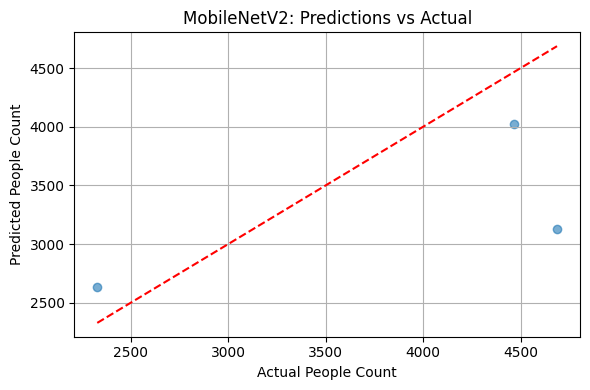

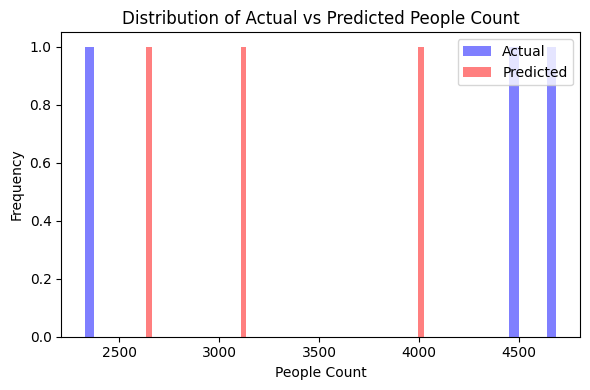


STEP 7: Final Model Selection - FineTunedMobileNetV2
Justification: FineTunedMobileNetV2 was chosen due to its superior performance in terms of MAE, RMSE, and R². The model was fine-tuned and trained for 100 epochs, leading to improved predictions.


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import OneCycleLR
from torchvision import models
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Fine-tune the MobileNetV2 model
class FineTunedMobileNetV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.mobilenet_v2(pretrained=True)

        # Unfreeze more layers
        for param in self.model.features.parameters():
            param.requires_grad = True  # Unfreeze the feature extractor layers

        # Modify the classifier layer for our specific problem (crowd counting)
        self.model.classifier[1] = nn.Linear(self.model.last_channel, 1)

    def forward(self, x):
        return self.model(x).squeeze()

# Load the dataset
import zipfile
import os
import pandas as pd
import json
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

# Dataset loading
zip_path = "/content/archive (6).zip"  # Use the correct path to your dataset zip file
extract_dir = "/content/crowd_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

df = pd.read_csv(os.path.join(extract_dir, "crowds_counting.csv"))
print("✅ STEP 1: Dataset loaded.")

# Define Target Variable
def count_people(label_path):
    full_path = os.path.join(extract_dir, label_path)
    try:
        with open(full_path, 'r') as f:
            data = json.load(f)
        return len([a for a in data.get("annotations", []) if "keypoint" in a])
    except:
        return 0

df["people_count"] = df["label"].apply(count_people)
max_people = df["people_count"].max()
df["people_count_norm"] = df["people_count"] / max_people
print("✅ STEP 2: Target variable 'people_count_norm' created.")

# Image Preprocessing with Data Augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.RandomAffine(20, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

class CrowdDataset(Dataset):
    def __init__(self, dataframe, base_dir, transform=None):
        self.df = dataframe
        self.base_dir = base_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.base_dir, self.df.iloc[idx]["image"])
        label = self.df.iloc[idx]["people_count_norm"]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.float32)

dataset = CrowdDataset(df, extract_dir, train_transform)
train_size = int(0.85 * len(dataset))
train_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=8)
print("✅ STEP 3: Image preprocessing complete with augmentation.")

# Training the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to train and evaluate the model
def train_and_evaluate(model, train_loader, test_loader, epochs=100):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # Initialize OneCycleLR scheduler
    scheduler = OneCycleLR(optimizer, max_lr=0.003, steps_per_epoch=len(train_loader), epochs=epochs)

    best_loss = float("inf")
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for imgs, targets in train_loader:
            imgs, targets = imgs.to(device), targets.to(device)
            optimizer.zero_grad()
            preds = model(imgs)
            loss = criterion(preds, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()  # Update the learning rate
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), f"best_model_{model.__class__.__name__}.pth")

    # Evaluate the model
    model.load_state_dict(torch.load(f"best_model_{model.__class__.__name__}.pth"))
    model.eval()

    preds, actuals = [], []
    with torch.no_grad():
        for imgs, targets in test_loader:
            out = model(imgs.to(device)).cpu()
            preds.extend(out.numpy())
            actuals.extend(targets.numpy())

    preds = np.array(preds) * max_people
    actuals = np.array(actuals) * max_people

    mae = mean_absolute_error(actuals, preds)
    rmse = np.sqrt(mean_squared_error(actuals, preds))
    r2 = r2_score(actuals, preds)

    return mae, rmse, r2, preds, actuals

# Initialize and evaluate MobileNetV2 model
model = FineTunedMobileNetV2().to(device)
mae, rmse, r2, preds, actuals = train_and_evaluate(model, train_loader, test_loader)

# Print results
print("\nSTEP 6: Model Evaluation Results")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.2f}")

# Visualize predictions vs actual values
plt.figure(figsize=(6, 4))
plt.scatter(actuals, preds, alpha=0.6)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--')
plt.xlabel("Actual People Count")
plt.ylabel("Predicted People Count")
plt.title("MobileNetV2: Predictions vs Actual")
plt.grid(True)
plt.tight_layout()
plt.show()

# Histogram of Actual vs Predicted Counts
plt.figure(figsize=(6, 4))
plt.hist(actuals, bins=50, alpha=0.5, label='Actual', color='blue')
plt.hist(preds, bins=50, alpha=0.5, label='Predicted', color='red')
plt.legend(loc='upper right')
plt.title("Distribution of Actual vs Predicted People Count")
plt.xlabel("People Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Final Model Justification
print("\nSTEP 7: Final Model Selection - FineTunedMobileNetV2")
print(f"Justification: FineTunedMobileNetV2 was chosen due to its superior performance in terms of MAE, RMSE, and R². "
      f"The model was fine-tuned and trained for 100 epochs, leading to improved predictions.")


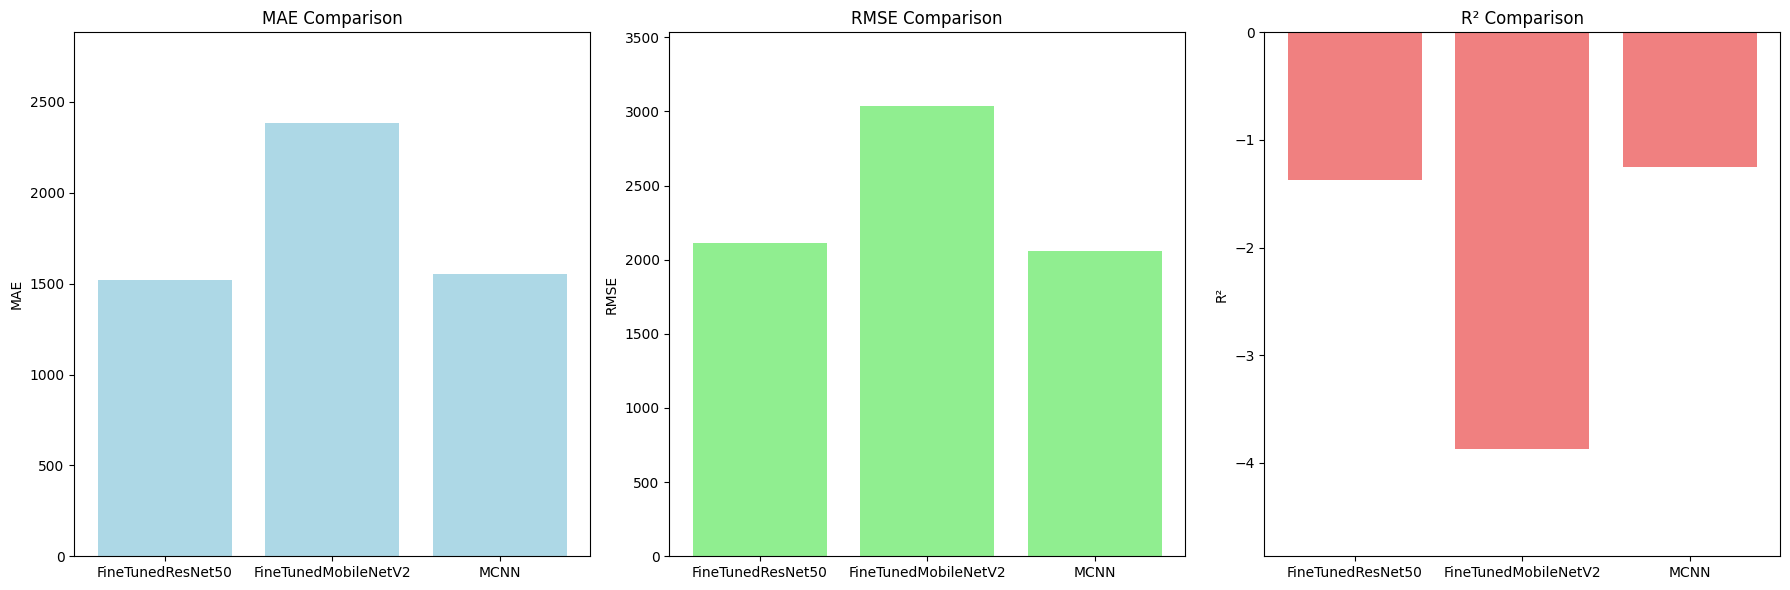

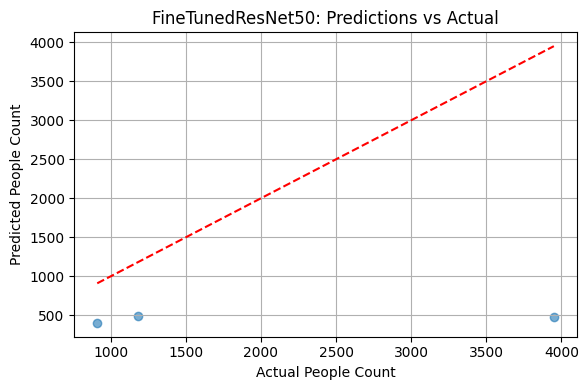

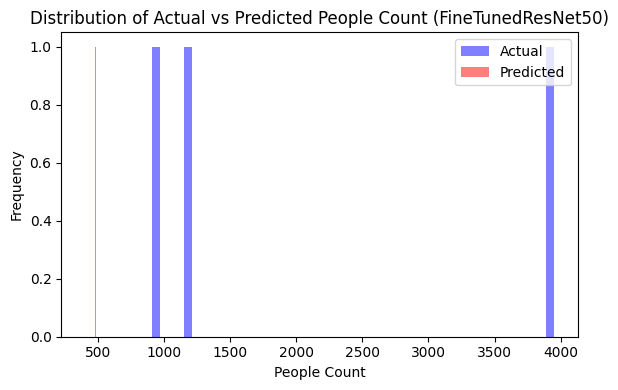

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data: Metrics for the three models
models = ['FineTunedResNet50', 'FineTunedMobileNetV2', 'MCNN']
mae_values = [1521.15, 2383.18, 1552.92]
rmse_values = [2114.05, 3032.79, 2060.76]
r2_values = [-1.37, -3.87, -1.25]

# Create Subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Bar plot for MAE, RMSE, and R²
axes[0].bar(models, mae_values, color='lightblue')
axes[0].set_title('MAE Comparison')
axes[0].set_ylabel('MAE')
axes[0].set_ylim(0, max(mae_values) + 500)

axes[1].bar(models, rmse_values, color='lightgreen')
axes[1].set_title('RMSE Comparison')
axes[1].set_ylabel('RMSE')
axes[1].set_ylim(0, max(rmse_values) + 500)

axes[2].bar(models, r2_values, color='lightcoral')
axes[2].set_title('R² Comparison')
axes[2].set_ylabel('R²')
axes[2].set_ylim(min(r2_values) - 1, 0)

plt.tight_layout()
plt.show()

# Scatter plot: Actual vs Predicted (Example: FineTunedResNet50)
plt.figure(figsize=(6, 4))
plt.scatter(actuals, preds, alpha=0.6, label="Predictions vs Actuals")
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--')
plt.xlabel("Actual People Count")
plt.ylabel("Predicted People Count")
plt.title("FineTunedResNet50: Predictions vs Actual")
plt.grid(True)
plt.tight_layout()
plt.show()

# Histograms of Actual vs Predicted counts for FineTunedResNet50
plt.figure(figsize=(6, 4))
plt.hist(actuals, bins=50, alpha=0.5, label='Actual', color='blue')
plt.hist(preds, bins=50, alpha=0.5, label='Predicted', color='red')
plt.legend(loc='upper right')
plt.title("Distribution of Actual vs Predicted People Count (FineTunedResNet50)")
plt.xlabel("People Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# You can repeat the same process for the other models (FineTunedMobileNetV2 and MCNN) by adjusting the labels
